In [ ]:
# Copyright: Bahar (Fatemeh) Safikhani

In [1]:
%load_ext autoreload
%autoreload 2

import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from scripts.Classifier import Classifier
from scripts.data_utils import dataset

In [2]:
rs = 1 # random state

In [3]:
scores_df = pd.DataFrame(
    columns=['method', 'mean_accuracy', 'acc_confidence_interval', 'mean_roc_auc', 'auc_confidence_interval', 'classifier']
) # Dataframe to store models and scores.

In [33]:
# Importing the dataset and splitting to training/validation/test sets
df, X_train, y_train, X_valid, y_valid, X_test, y_test = dataset(ratio=[0.7, 0.2, 0.1], random_state=rs)
X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train, y_valid])

There is no data leakage between patients.


# Feature Selection and Dataset Insight

In [26]:
keep_percentile = 70 # percent of feeatures to keep in SelectPercentile

selector = SelectPercentile(chi2, percentile=keep_percentile)
selector.fit(X_train, y_train)

selected_features_indices = selector.get_support(indices=True)
selected_features = list(X_train.columns[selected_features_indices])
selected_df = df.loc[:, ['Diagnosis'] + selected_features].copy(deep=True)

print(f"selected {len(selected_features)} features:\n{selected_features}")

selected 21 features:
['radius_mean', 'texture_mean', 'perimeter_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst']


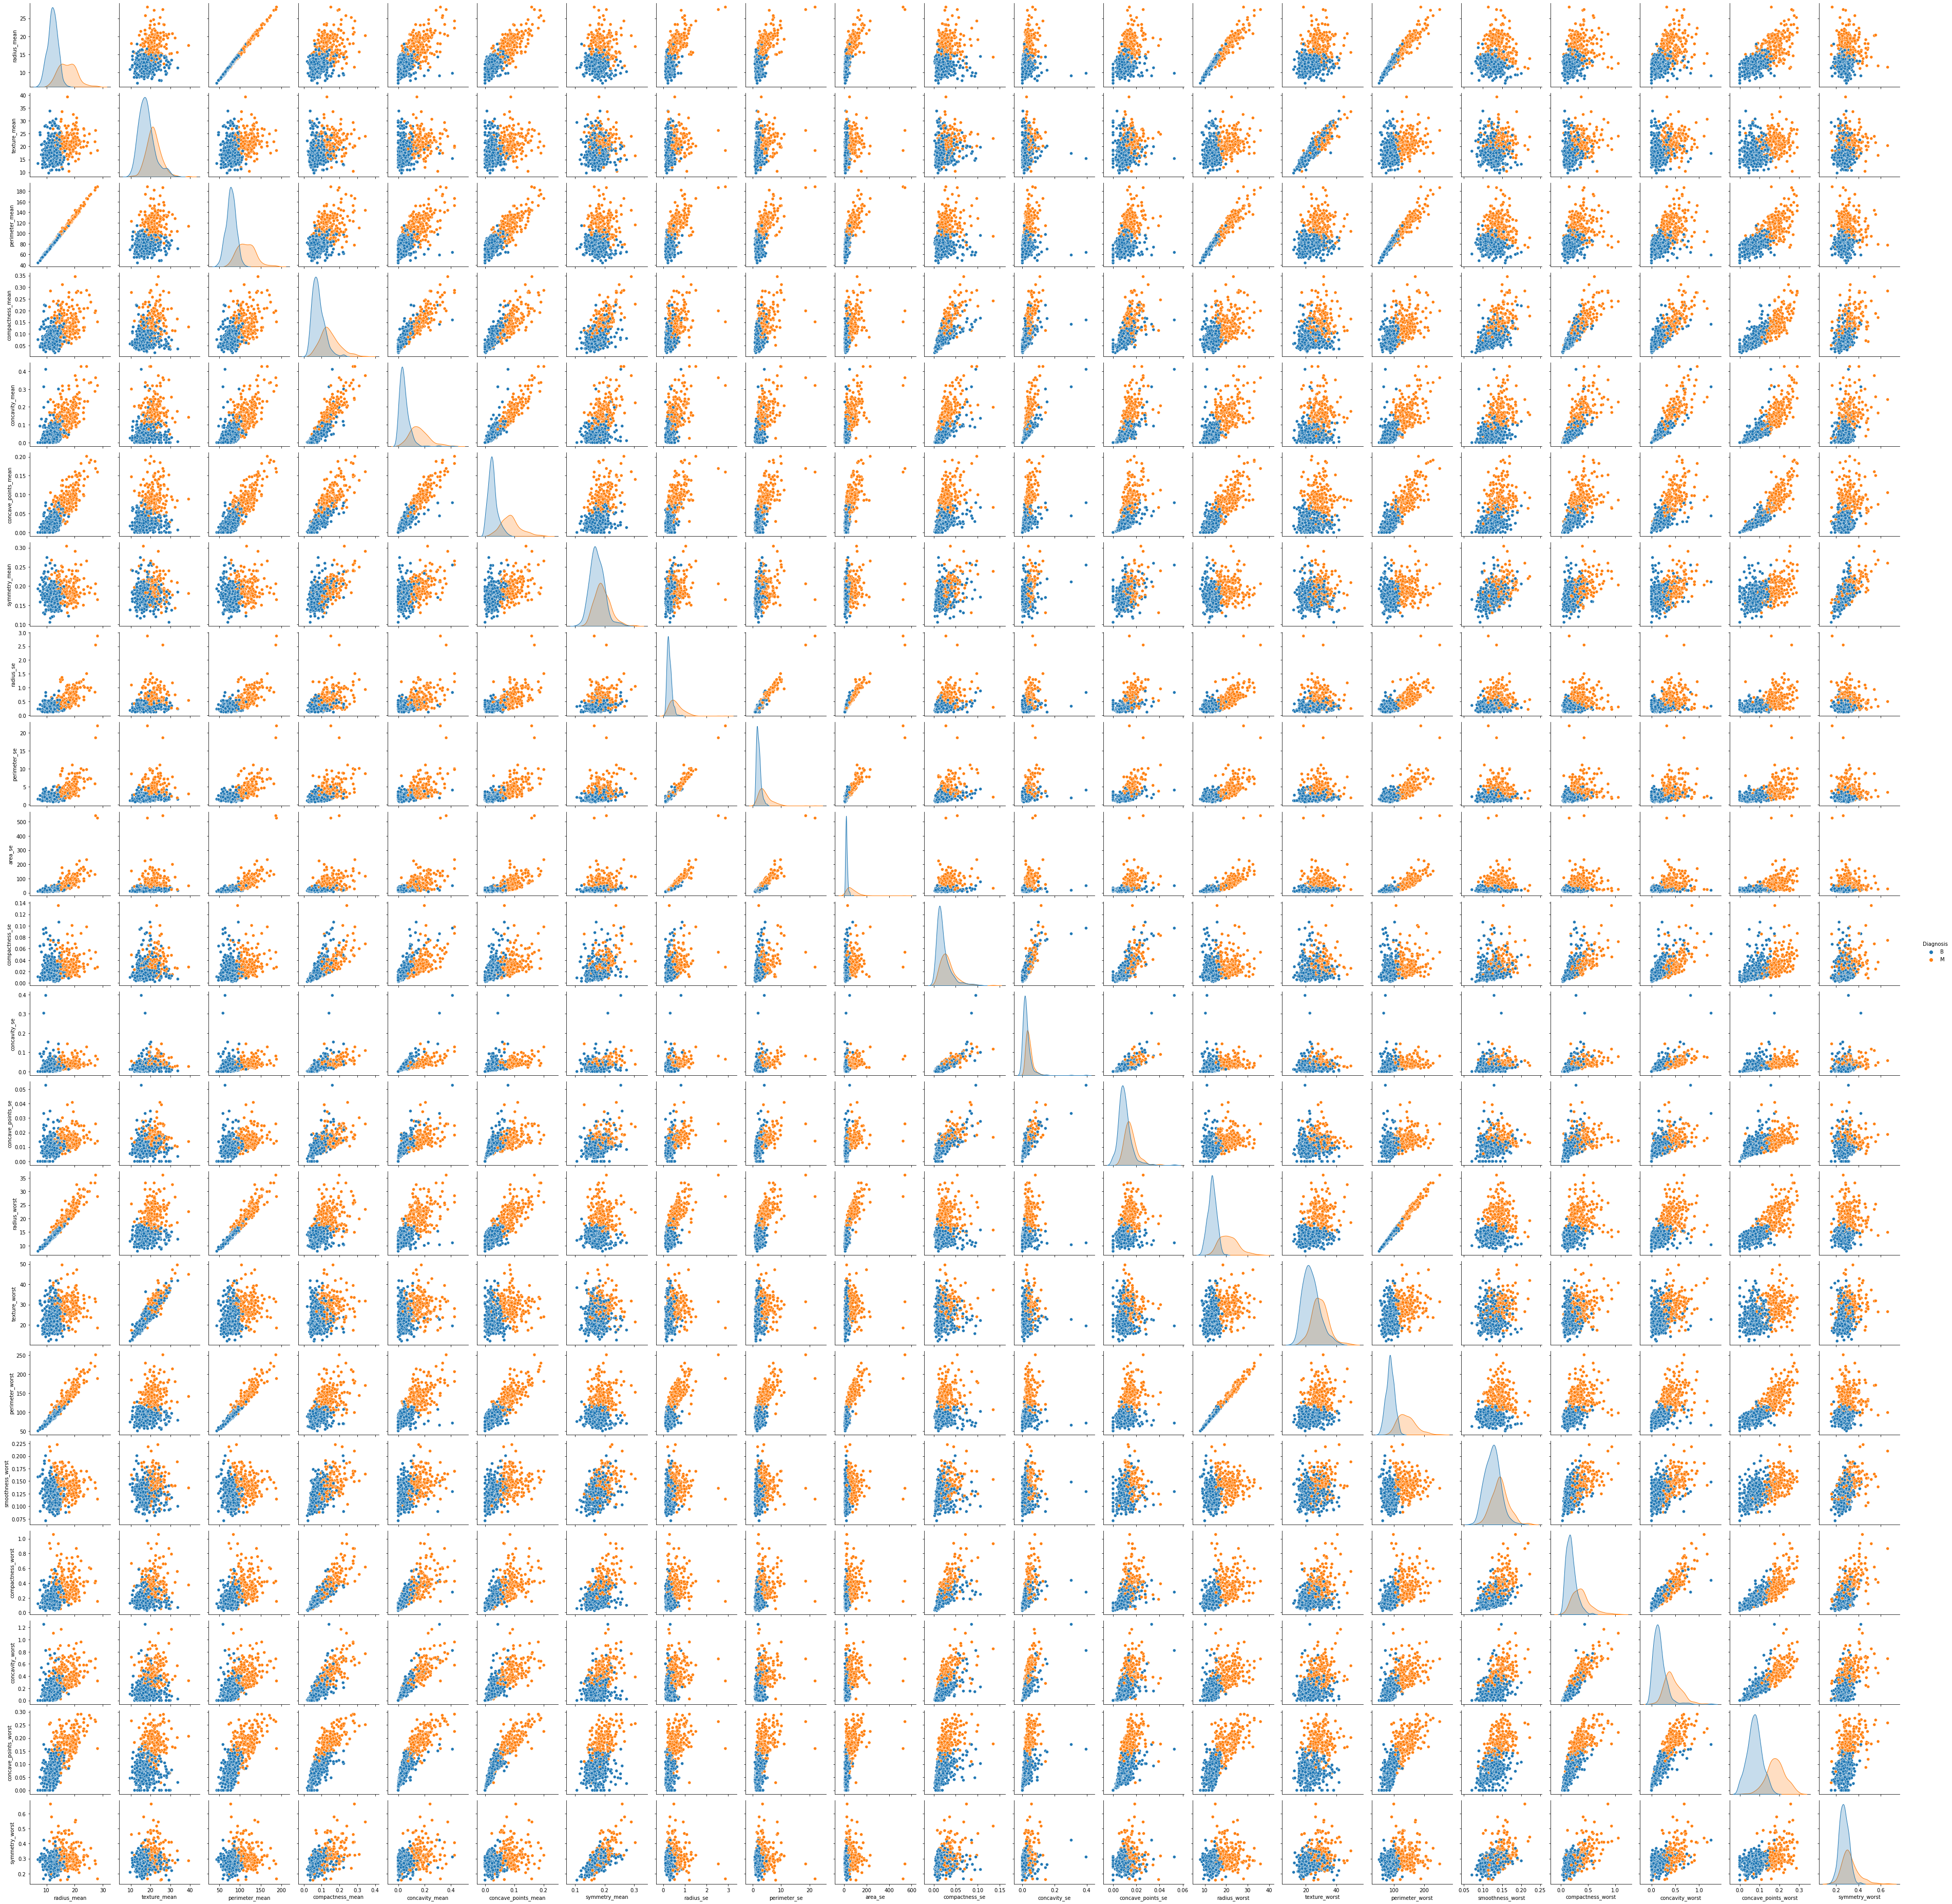

In [6]:
g = sns.pairplot(selected_df, hue="Diagnosis", diag_kind="kde")
fig = g.fig
fig.savefig('pairplot.pdf', format='pdf')

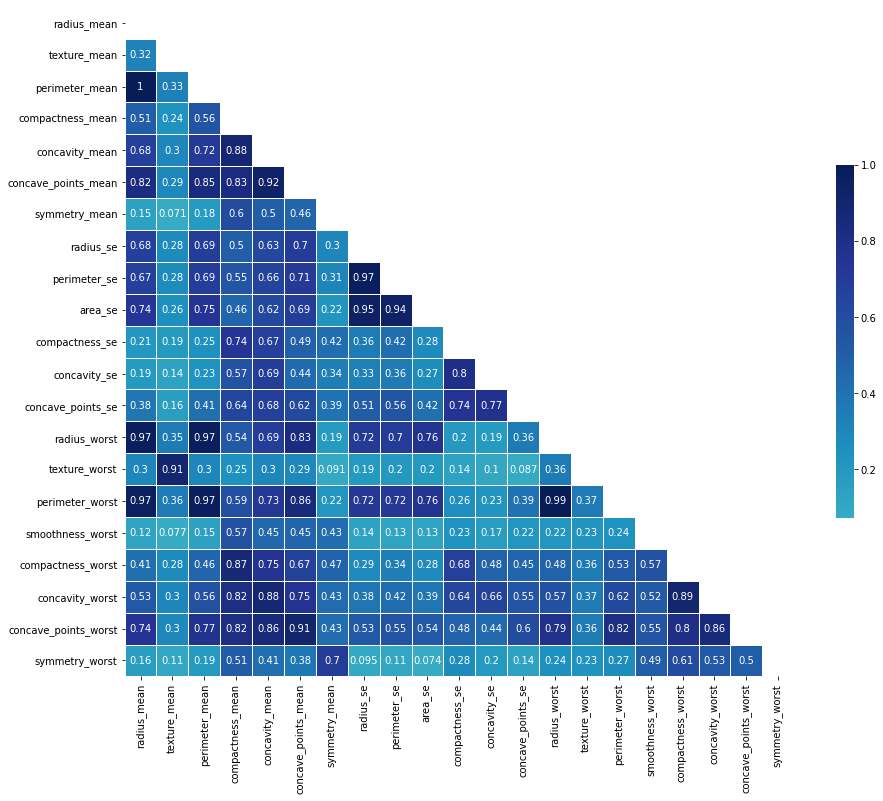

In [27]:
corr = selected_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', vmax=1, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.show()

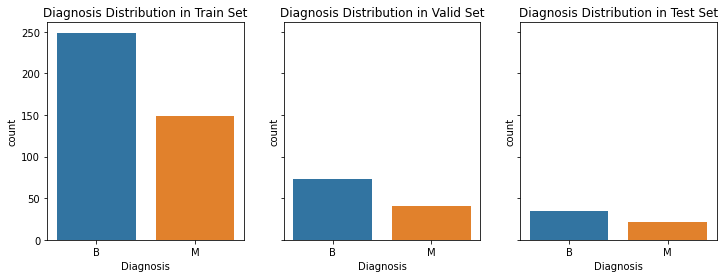

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].set_title('Diagnosis Distribution in Train Set')
sns.countplot(ax=axes[0], x='Diagnosis', data=pd.DataFrame(y_train))

axes[1].set_title('Diagnosis Distribution in Valid Set')
sns.countplot(ax=axes[1], x='Diagnosis', data=pd.DataFrame(y_valid))

axes[2].set_title('Diagnosis Distribution in Test Set')
sns.countplot(ax=axes[2], x='Diagnosis', data=pd.DataFrame(y_test))
plt.show()

# Models Inputs

In [9]:
scoring = 'accuracy' # scoring metric
alpha = 0.95 # confidence
cv = 5 # number of cross validation folds

# List of estimator calls
estimators = [
    LogisticRegression(random_state=rs),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    KNeighborsClassifier(n_jobs=-1),
    DecisionTreeClassifier(random_state=rs),
    SVC(random_state=rs)
]

# Dictionary of parameter grids to search for hyperparameter optimization
param_grids = {}

param_grids['Logistic Regression'] = {
    'C': [10, 1, 0.1, 0.01],
    'solver':['liblinear', 'saga', 'sag'],
    'penalty': ['l1', 'l2', None],
    'max_iter': [1, 5, 10, 20, 50, 100]
}

param_grids['Naive Bayes'] = {'var_smoothing': [1e-8, 5e-8, 1e-9, 5e-9, 1e-10]}

param_grids['Linear Discriminant Analysis'] = {'solver': ['svd', 'lsqr', 'eigen']}

param_grids['K-Nearest Neighbors'] = {
    'n_neighbors': [3, 5, 8, 10, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

param_grids['Decision Tree'] = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4]
}

param_grids['Support Vector Machines'] = {
    'C': [0.1, 0.5, 1, 1.25, 1.5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'shrinking': [True, False],
    'probability': [True, False]
}

# Making sure for every estimator, we one grid to search
assert(len(estimators) == len(param_grids))

# Running Models

===================== logisticregression =====================
logisticregression instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'logisticregression__C': 0.1, 'logisticregression__max_iter': 5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}

logisticregression model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.968515
confidence interval = [0.944328, 0.984321]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.993339
confidence interval = [0.985287, 0.998565]

=========================== Training ============================
model is successfully trained on training data.

indices of the selected features in SelectKBest:
[ 0  1  2  5  6  7  8 10 12 13 15 16 1

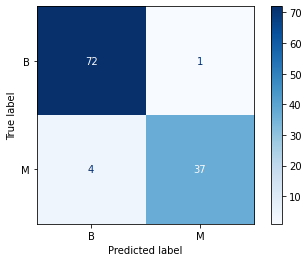

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        73
           M       0.97      0.90      0.94        41

    accuracy                           0.96       114
   macro avg       0.96      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.95      0.99      0.90      0.97      0.94      0.90        73
          M       0.97      0.90      0.99      0.94      0.94      0.88        41

avg / total       0.96      0.96      0.93      0.96      0.94      0.89       114

*****************************************************************
roc plot:



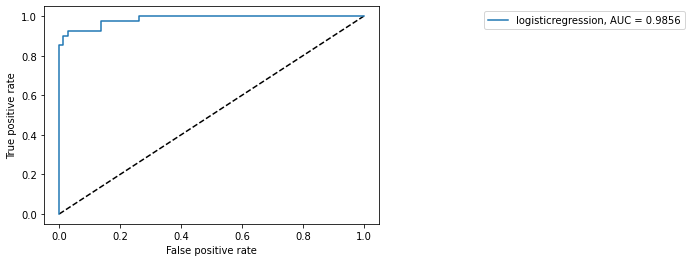

*****************************************************************
precision recall plot:



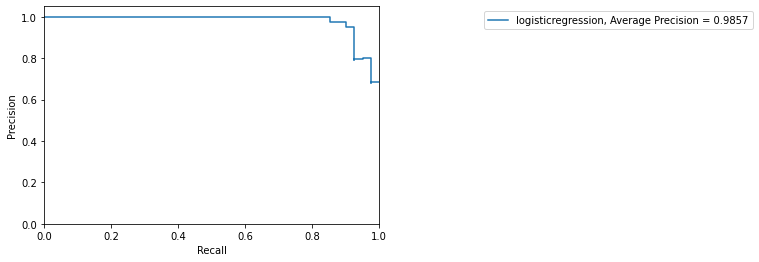

*****************************************************************
callibration plot:



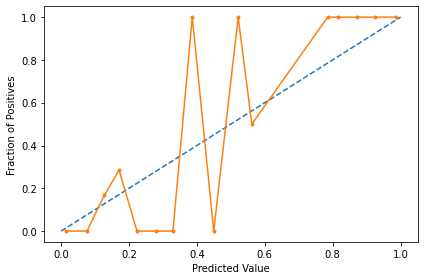

===================== gaussiannb =====================
gaussiannb instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'gaussiannb__var_smoothing': 1e-08}

gaussiannb model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.935315
confidence interval = [0.909079, 0.958811]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.984934
confidence interval = [0.966466, 0.993993]

=========================== Training ============================
model is successfully trained on training data.

indices of the selected features in SelectKBest:
[ 0  1  2  5  6  7  8 10 12 13 15 16 17 20 21 22 24 25 26 27 28]

selected features in SelectPercentile:
['radius_mean', 'texture_mean', 'perimeter_mean', 'compactness_mea

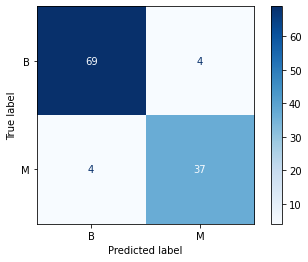

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.95      0.95      0.95        73
           M       0.90      0.90      0.90        41

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.95      0.95      0.90      0.95      0.92      0.86        73
          M       0.90      0.90      0.95      0.90      0.92      0.85        41

avg / total       0.93      0.93      0.92      0.93      0.92      0.85       114

*****************************************************************
roc plot:



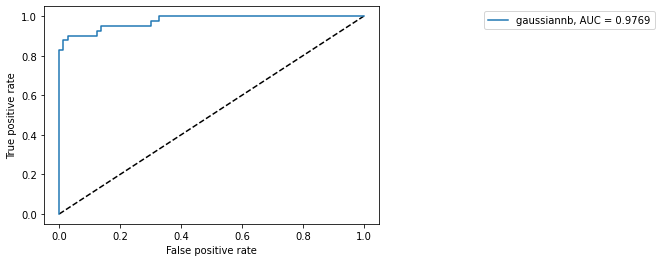

*****************************************************************
precision recall plot:



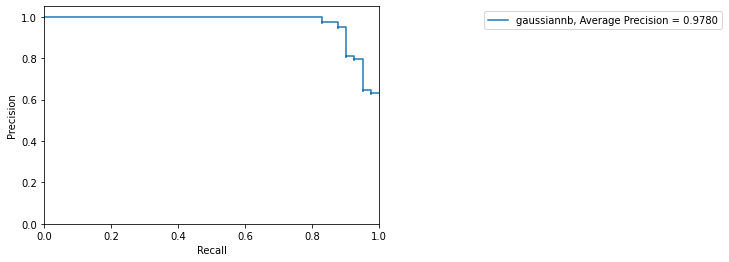

*****************************************************************
callibration plot:



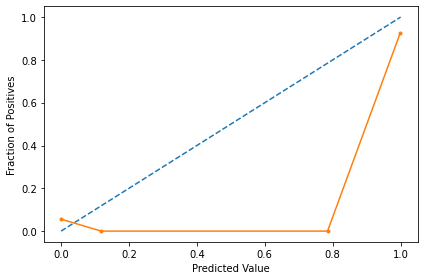

===================== lineardiscriminantanalysis =====================
lineardiscriminantanalysis instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'lineardiscriminantanalysis__solver': 'svd'}

lineardiscriminantanalysis model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.944627
confidence interval = [0.919340, 0.968756]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.984787
confidence interval = [0.967957, 0.994601]

=========================== Training ============================
model is successfully trained on training data.

indices of the selected features in SelectKBest:
[ 0  1  2  5  6  7  8 10 12 13 15 16 17 20 21 22 24 25 26 27 28]

selected features in SelectPercentile:
['radius_

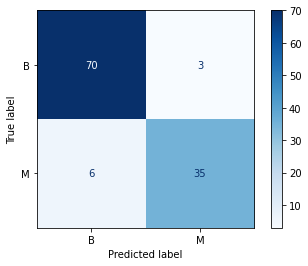

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.92      0.96      0.94        73
           M       0.92      0.85      0.89        41

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.92      0.96      0.85      0.94      0.90      0.83        73
          M       0.92      0.85      0.96      0.89      0.90      0.81        41

avg / total       0.92      0.92      0.89      0.92      0.90      0.82       114

*****************************************************************
roc plot:



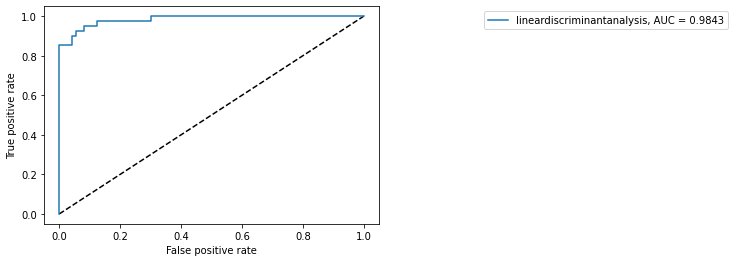

*****************************************************************
precision recall plot:



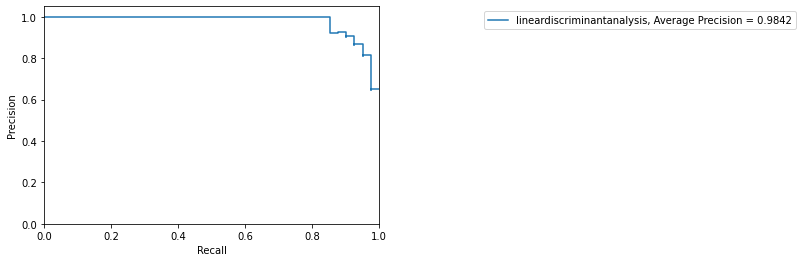

*****************************************************************
callibration plot:



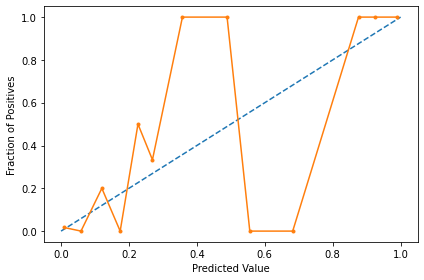

===================== kneighborsclassifier =====================
kneighborsclassifier instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}

kneighborsclassifier model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.952773
confidence interval = [0.923379, 0.972506]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.985748
confidence interval = [0.970401, 0.995615]

=========================== Training ============================
model is successfully trained on training data.

indices of the selected features in SelectKBest:
[ 0  1  2  5  6  7  8 10 12 13 15 16 17 20 2

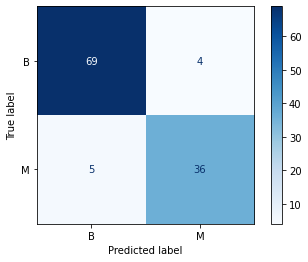

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.93      0.95      0.94        73
           M       0.90      0.88      0.89        41

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.93      0.95      0.88      0.94      0.91      0.84        73
          M       0.90      0.88      0.95      0.89      0.91      0.82        41

avg / total       0.92      0.92      0.90      0.92      0.91      0.83       114

*****************************************************************
roc plot:



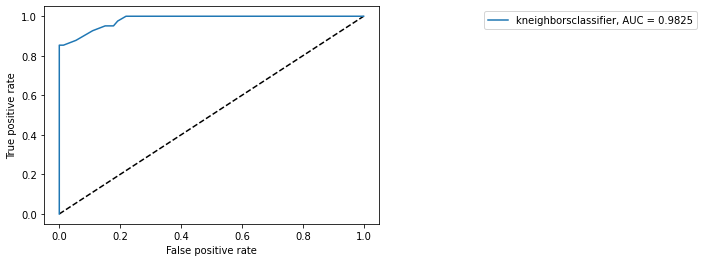

*****************************************************************
precision recall plot:



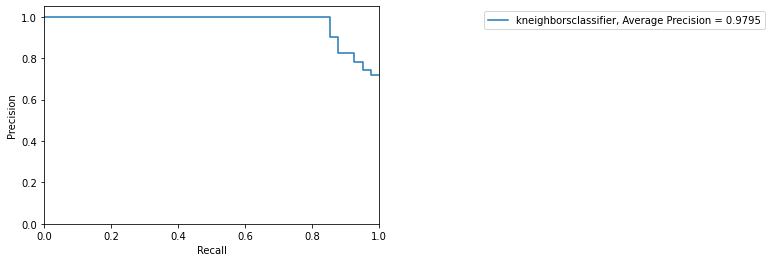

*****************************************************************
callibration plot:



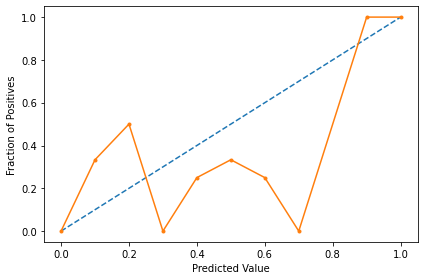

===================== decisiontreeclassifier =====================
decisiontreeclassifier instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 2, 'decisiontreeclassifier__splitter': 'best'}

decisiontreeclassifier model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.922600
confidence interval = [0.884848, 0.954440]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.937762
confidence interval = [0.904814, 0.969331]

=========================== Training ============================
model is successfully trained on training 

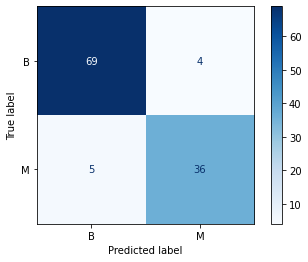

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.93      0.95      0.94        73
           M       0.90      0.88      0.89        41

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.93      0.95      0.88      0.94      0.91      0.84        73
          M       0.90      0.88      0.95      0.89      0.91      0.82        41

avg / total       0.92      0.92      0.90      0.92      0.91      0.83       114

*****************************************************************
roc plot:



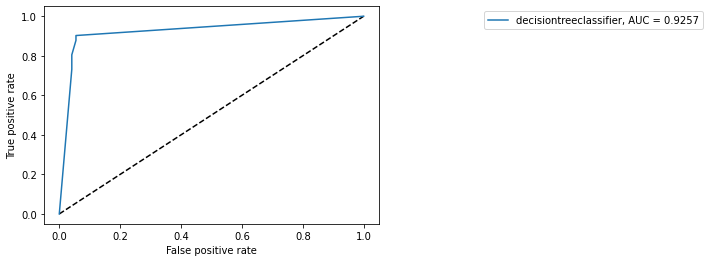

*****************************************************************
precision recall plot:



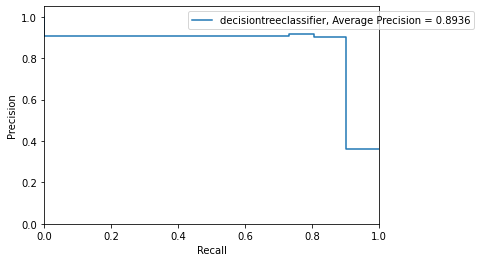

*****************************************************************
callibration plot:



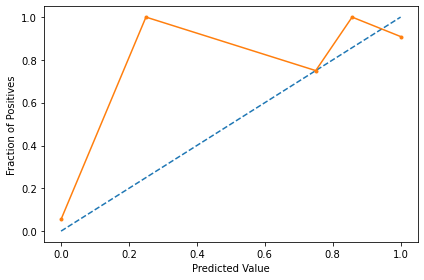

===================== svc =====================
svc instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'svc__C': 0.1, 'svc__kernel': 'linear', 'svc__probability': True, 'svc__shrinking': True}

svc model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.969579
confidence interval = [0.948645, 0.987977]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.993099
confidence interval = [0.983991, 0.998327]

=========================== Training ============================
model is successfully trained on training data.

indices of the selected features in SelectKBest:
[ 0  1  2  5  6  7  8 10 12 13 15 16 17 20 21 22 24 25 26 27 28]

selected features in SelectPercentile:
['radius_mean', 'texture_mean', '

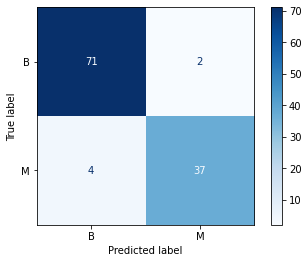

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.95      0.97      0.96        73
           M       0.95      0.90      0.92        41

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.95      0.97      0.90      0.96      0.94      0.88        73
          M       0.95      0.90      0.97      0.92      0.94      0.87        41

avg / total       0.95      0.95      0.93      0.95      0.94      0.88       114

*****************************************************************
roc plot:



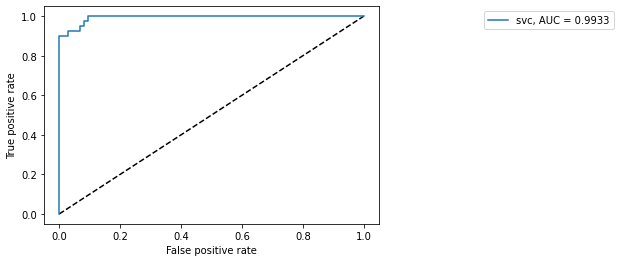

*****************************************************************
precision recall plot:



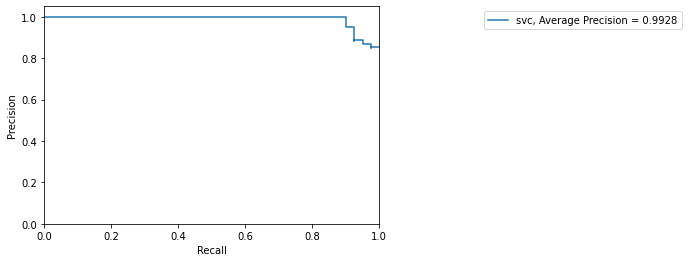

*****************************************************************
callibration plot:



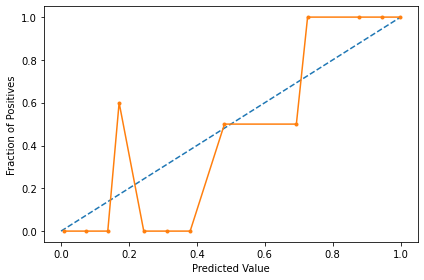

In [10]:
for estimator, estimator_name in zip(estimators, param_grids):
    clf = Classifier(estimator, random_state=rs, keep_percentile=keep_percentile, gen_report=True)
    clf.hp_optim(X_train_valid, y_train_valid, param_grids[estimator_name], scoring=scoring, cv=cv, verbose=False)
    clf.bootstrap_acc(X_train_valid, y_train_valid, bootstraps=100, fold_ratio=0.7)
    clf.bootstrap_auc(X_train_valid, y_train_valid, bootstraps=100, fold_ratio=0.7)
    clf.get_confidence_interval(alpha=alpha)
    clf.fit_model(X_train, y_train)
    clf.results(X_valid, y_valid)

    result_dict = {
        'method': estimator_name,
        'mean_accuracy': clf.CI['accuracy'][0],
        'acc_confidence_interval': f"[{clf.CI['accuracy'][1]:.6f}, {clf.CI['accuracy'][2]:.6f}]",
        'mean_roc_auc': clf.CI['roc_auc'][0],
        'auc_confidence_interval': f"[{clf.CI['roc_auc'][1]:.6f}, {clf.CI['roc_auc'][2]:.6f}]",
        'classifier': clf
    }

    if not (scores_df['method'] == result_dict['method']).any():
        scores_df = scores_df.append(result_dict, ignore_index=True)

# Results

Performance of the models on validation set:
                         method  mean_accuracy acc_confidence_interval  \
0           Logistic Regression       0.968515    [0.944328, 0.984321]   
5       Support Vector Machines       0.969579    [0.948645, 0.987977]   
3           K-Nearest Neighbors       0.952773    [0.923379, 0.972506]   
1                   Naive Bayes       0.935315    [0.909079, 0.958811]   
2  Linear Discriminant Analysis       0.944627    [0.919340, 0.968756]   
4                 Decision Tree       0.922600    [0.884848, 0.954440]   

   mean_roc_auc auc_confidence_interval  
0      0.993339    [0.985287, 0.998565]  
5      0.993099    [0.983991, 0.998327]  
3      0.985748    [0.970401, 0.995615]  
1      0.984934    [0.966466, 0.993993]  
2      0.984787    [0.967957, 0.994601]  
4      0.937762    [0.904814, 0.969331]  
********************************************


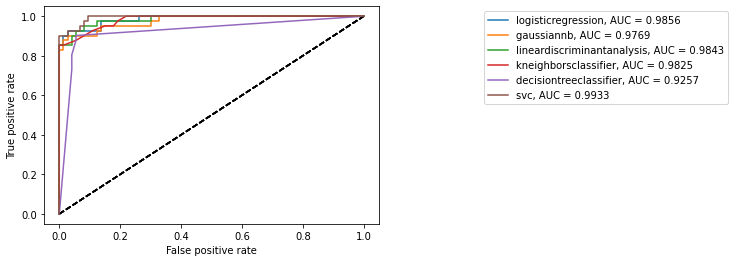

********************************************


<Figure size 432x288 with 0 Axes>

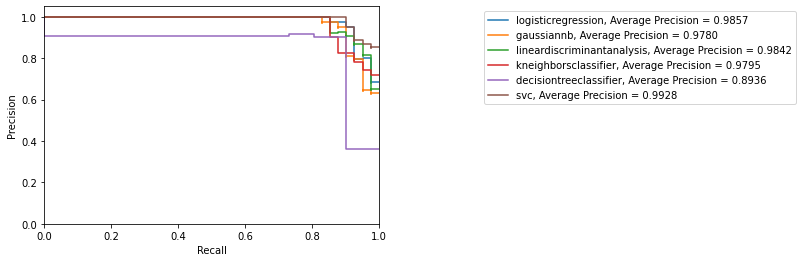

In [11]:
print("Performance of the models on validation set:")
print(scores_df[
    ['method', 'mean_accuracy', 'acc_confidence_interval', 'mean_roc_auc', 'auc_confidence_interval']
].sort_values(by='mean_roc_auc', ascending=False))

print("********************************************")

plt.figure()
for _,row in scores_df.iterrows():
    clf = row['classifier']
    clf.roc_plot(X_valid, y_valid)

plt.show()
    
print("********************************************")

plt.figure()
for _,row in scores_df.iterrows():
    clf = row['classifier']
    clf.pr_plot(X_valid, y_valid)
    
plt.show()

In [12]:
best = scores_df.sort_values(by='mean_roc_auc', ascending=False).iloc[0]
print(f"""
The best model is '{best['method']}' with an average roc_auc score of {best['mean_roc_auc']:.6f} 
and a confidence interval of {best['auc_confidence_interval']} at {100 * alpha}% confidence.
It also has an average accuracy score of {best['mean_accuracy']:.6f} 
and a confidence interval of {best['acc_confidence_interval']} at {100 * alpha}% confidence.
""")


The best model is 'Logistic Regression' with an average roc_auc score of 0.993339 
and a confidence interval of [0.985287, 0.998565] at 95.0% confidence.
It also has an average accuracy score of 0.968515 
and a confidence interval of [0.944328, 0.984321] at 95.0% confidence.



The results of the best model on the test set:

============================ Results ============================
accuracy score = 1.0
*****************************************************************
roc area under the curve = 1.0
*****************************************************************
average precision (AP) from prediction scores = 0.9999999999999999
*****************************************************************
confusion matrix plot:


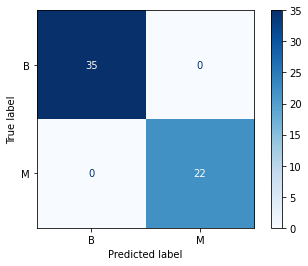

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       1.00      1.00      1.00        35
           M       1.00      1.00      1.00        22

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       1.00      1.00      1.00      1.00      1.00      1.00        35
          M       1.00      1.00      1.00      1.00      1.00      1.00        22

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        57

*****************************************************************
roc plot:



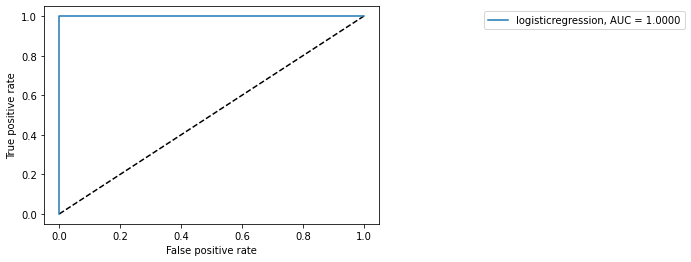

*****************************************************************
precision recall plot:



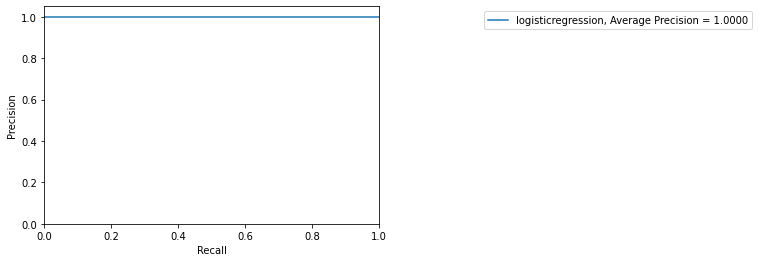

*****************************************************************
callibration plot:



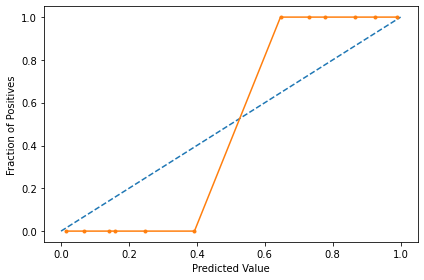

In [13]:
print("The results of the best model on the test set:\n")
best_model = best.classifier
best_model.results(X_valid=X_test, y_valid=y_test, gen_report=True)

# Ensemble Methods

In [14]:
from imblearn.ensemble import (
    EasyEnsembleClassifier,
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier
)

## Models Inputs

In [15]:
# List of estimator calls
ensemble_estimators = [
    EasyEnsembleClassifier(base_estimator=best_model.estimator, random_state=rs, n_jobs=-1),
    BalancedBaggingClassifier(base_estimator=best_model.estimator, random_state=rs, n_jobs=-1),
    BalancedRandomForestClassifier(random_state=rs, n_jobs=-1),
]

# Dictionary of parameter grids to search for hyperparameter optimization
ensemble_param_grids = {}

ensemble_param_grids['Easy Ensemble'] = {
    'n_estimators': [5, 10, 15, 20, 25],
    'sampling_strategy': ['majority', 'not majority', 'all'],
    'replacement': [True, False]
}

ensemble_param_grids['Balanced Bagging'] = {
    'n_estimators': [5, 10, 15, 20],
    'sampling_strategy': ['majority', 'not majority', 'all'],
    'replacement': [True, False],
    'bootstrap':[True, False],
    'oob_score': [True, False]
}

ensemble_param_grids['Balanced Random Forest'] = {
    'n_estimators': [50, 80, 100, 120, 150, 200],
    'criterion': ['gini', 'entropy'],
    'sampling_strategy': ['majority', 'not majority', 'all'],
    'replacement': [True, False],
    'bootstrap':[True, False]
}

# Making sure for every estimator, we one grid to search
assert(len(ensemble_estimators) == len(ensemble_param_grids))

## Running Models

===================== easyensembleclassifier =====================
easyensembleclassifier instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'easyensembleclassifier__n_estimators': 5, 'easyensembleclassifier__replacement': False, 'easyensembleclassifier__sampling_strategy': 'majority'}

easyensembleclassifier model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.967330
confidence interval = [0.952658, 0.983711]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.992403
confidence interval = [0.983474, 0.998257]

=========================== Training ============================
model is successfully trained on training data.

indices of the selected features in SelectKBest:
[ 0  1  2  5  6  7  8 10 

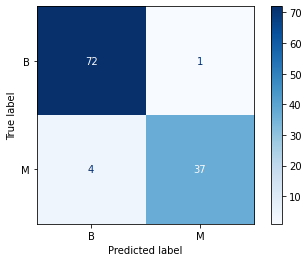

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        73
           M       0.97      0.90      0.94        41

    accuracy                           0.96       114
   macro avg       0.96      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.95      0.99      0.90      0.97      0.94      0.90        73
          M       0.97      0.90      0.99      0.94      0.94      0.88        41

avg / total       0.96      0.96      0.93      0.96      0.94      0.89       114

*****************************************************************
roc plot:



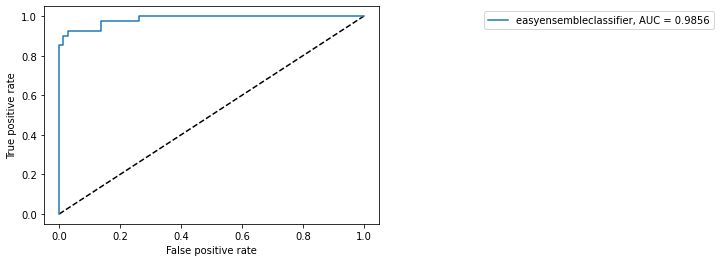

*****************************************************************
precision recall plot:



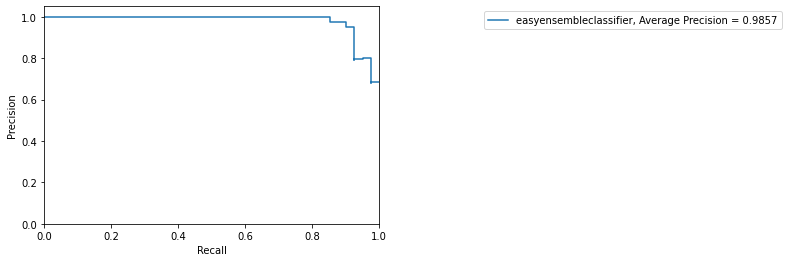

*****************************************************************
callibration plot:



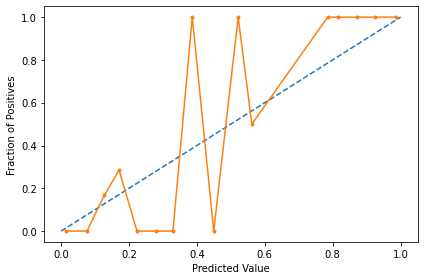

===================== balancedbaggingclassifier =====================
balancedbaggingclassifier instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'balancedbaggingclassifier__bootstrap': True, 'balancedbaggingclassifier__n_estimators': 20, 'balancedbaggingclassifier__oob_score': True, 'balancedbaggingclassifier__replacement': False, 'balancedbaggingclassifier__sampling_strategy': 'not majority'}

balancedbaggingclassifier model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.965619
confidence interval = [0.942679, 0.987931]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.992182
confidence interval = [0.985214, 0.998523]

=========================== Training ============================
model is

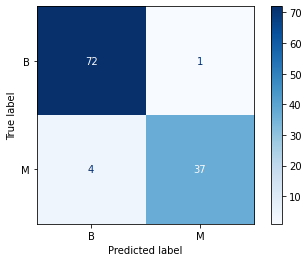

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        73
           M       0.97      0.90      0.94        41

    accuracy                           0.96       114
   macro avg       0.96      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.95      0.99      0.90      0.97      0.94      0.90        73
          M       0.97      0.90      0.99      0.94      0.94      0.88        41

avg / total       0.96      0.96      0.93      0.96      0.94      0.89       114

*****************************************************************
roc plot:



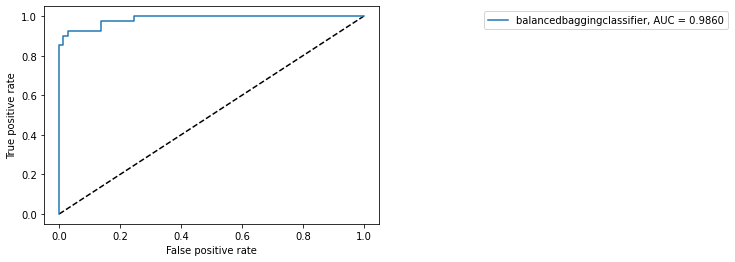

*****************************************************************
precision recall plot:



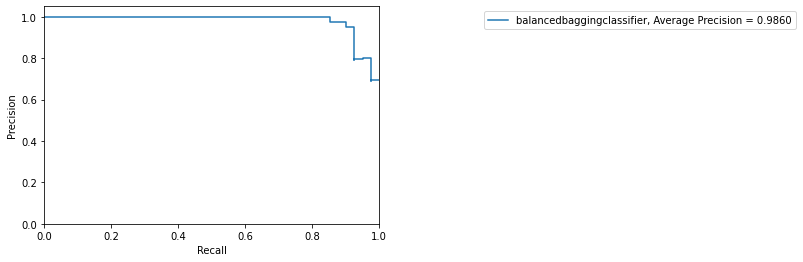

*****************************************************************
callibration plot:



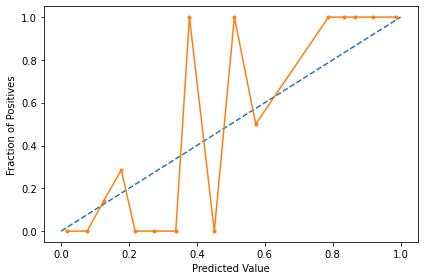

===================== balancedrandomforestclassifier =====================
balancedrandomforestclassifier instance created successfully!

=========================== HP Tuning ===========================
hyperparameter tuning finished successfully!

best hyperparameters found by grid search:
{'balancedrandomforestclassifier__bootstrap': True, 'balancedrandomforestclassifier__criterion': 'entropy', 'balancedrandomforestclassifier__n_estimators': 150, 'balancedrandomforestclassifier__replacement': False, 'balancedrandomforestclassifier__sampling_strategy': 'not majority'}

balancedrandomforestclassifier model parameters updated to the best found values!

======================= Boot Strappping =======================
scoring metric: accuracy
mean scores = 0.953510
confidence interval = [0.925300, 0.976334]

======================= Boot Strappping =======================
scoring metric: roc_auc
mean scores = 0.989641
confidence interval = [0.980310, 0.997897]

=========================== 

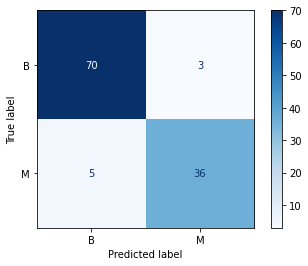

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       0.93      0.96      0.95        73
           M       0.92      0.88      0.90        41

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       0.93      0.96      0.88      0.95      0.92      0.85        73
          M       0.92      0.88      0.96      0.90      0.92      0.84        41

avg / total       0.93      0.93      0.91      0.93      0.92      0.84       114

*****************************************************************
roc plot:



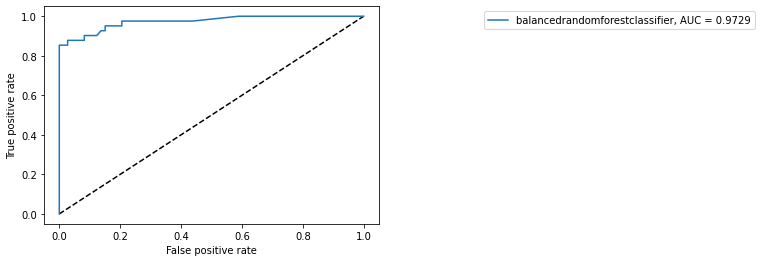

*****************************************************************
precision recall plot:



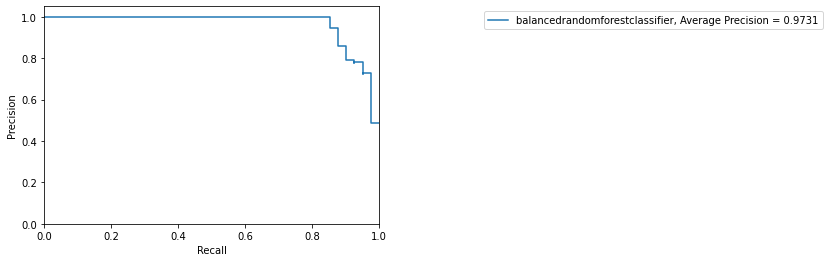

*****************************************************************
callibration plot:



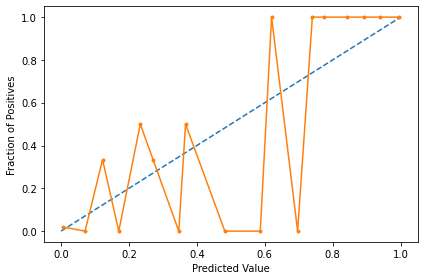

In [16]:
for estimator, estimator_name in zip(ensemble_estimators, ensemble_param_grids):
    clf = Classifier(estimator, random_state=rs, keep_percentile=keep_percentile, gen_report=True)
    clf.hp_optim(X_train_valid, y_train_valid, ensemble_param_grids[estimator_name], scoring=scoring, cv=cv, verbose=False)
    clf.bootstrap_acc(X_train_valid, y_train_valid, bootstraps=100, fold_ratio=0.7)
    clf.bootstrap_auc(X_train_valid, y_train_valid, bootstraps=100, fold_ratio=0.7)
    clf.get_confidence_interval(alpha=alpha)
    clf.fit_model(X_train, y_train)
    cvscores = clf.cross_validate(X_train_valid, y_train_valid, scoring=scoring, cv=cv)
    clf.results(X_valid, y_valid)

    result_dict = {
        'method': estimator_name,
        'mean_accuracy': clf.CI['accuracy'][0],
        'acc_confidence_interval': f"[{clf.CI['accuracy'][1]:.6f}, {clf.CI['accuracy'][2]:.6f}]",
        'mean_roc_auc': clf.CI['roc_auc'][0],
        'auc_confidence_interval': f"[{clf.CI['roc_auc'][1]:.6f}, {clf.CI['roc_auc'][2]:.6f}]",
        'classifier': clf
    }

    if not (scores_df['method'] == result_dict['method']).any():
        scores_df = scores_df.append(result_dict, ignore_index=True)

# Results with Ensemble Methods

Performance of the models on validation set:
                         method  mean_accuracy acc_confidence_interval  \
0           Logistic Regression       0.968515    [0.944328, 0.984321]   
5       Support Vector Machines       0.969579    [0.948645, 0.987977]   
6                 Easy Ensemble       0.967330    [0.952658, 0.983711]   
7              Balanced Bagging       0.965619    [0.942679, 0.987931]   
8        Balanced Random Forest       0.953510    [0.925300, 0.976334]   
3           K-Nearest Neighbors       0.952773    [0.923379, 0.972506]   
1                   Naive Bayes       0.935315    [0.909079, 0.958811]   
2  Linear Discriminant Analysis       0.944627    [0.919340, 0.968756]   
4                 Decision Tree       0.922600    [0.884848, 0.954440]   

   mean_roc_auc auc_confidence_interval  
0      0.993339    [0.985287, 0.998565]  
5      0.993099    [0.983991, 0.998327]  
6      0.992403    [0.983474, 0.998257]  
7      0.992182    [0.985214, 0.998523]  
8   

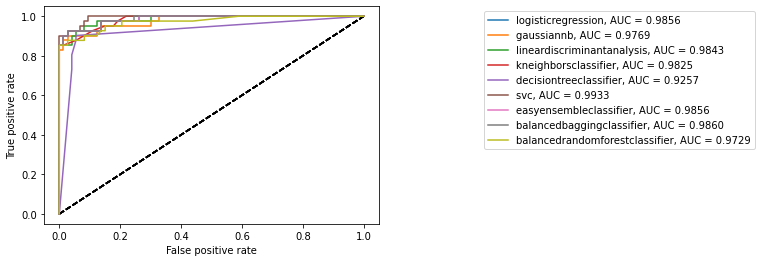

********************************************


<Figure size 432x288 with 0 Axes>

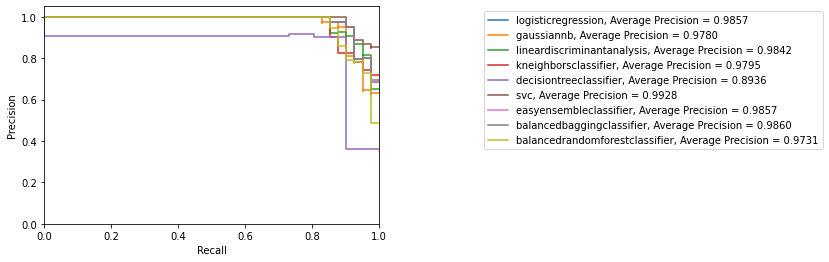

In [17]:
print("Performance of the models on validation set:")
print(scores_df[
    ['method', 'mean_accuracy', 'acc_confidence_interval', 'mean_roc_auc', 'auc_confidence_interval']
].sort_values(by='mean_roc_auc', ascending=False))

print("********************************************")

plt.figure()
for _,row in scores_df.iterrows():
    clf = row['classifier']
    clf.roc_plot(X_valid, y_valid)

plt.show()
    
print("********************************************")

plt.figure()
for _,row in scores_df.iterrows():
    clf = row['classifier']
    clf.pr_plot(X_valid, y_valid)
    
plt.show()

In [18]:
final_best = scores_df.sort_values(by='mean_roc_auc', ascending=False).iloc[0]
print(f"""
The best model is '{final_best['method']}' with an average roc_auc score of {final_best['mean_roc_auc']:.6f} 
and a confidence interval of {final_best['auc_confidence_interval']} at {100 * alpha}% confidence.
It also has an average accuracy score of {final_best['mean_accuracy']:.6f} 
and a confidence interval of {final_best['acc_confidence_interval']} at {100 * alpha}% confidence.
""")


The best model is 'Logistic Regression' with an average roc_auc score of 0.993339 
and a confidence interval of [0.985287, 0.998565] at 95.0% confidence.
It also has an average accuracy score of 0.968515 
and a confidence interval of [0.944328, 0.984321] at 95.0% confidence.



The results of the final best model on the test set:

============================ Results ============================
accuracy score = 1.0
*****************************************************************
roc area under the curve = 1.0
*****************************************************************
average precision (AP) from prediction scores = 0.9999999999999999
*****************************************************************
confusion matrix plot:


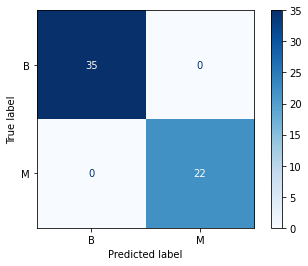

*****************************************************************
classification report:

              precision    recall  f1-score   support

           B       1.00      1.00      1.00        35
           M       1.00      1.00      1.00        22

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

*****************************************************************
classification report based on metrics used with imbalanced dataset:

                   pre       rec       spe        f1       geo       iba       sup

          B       1.00      1.00      1.00      1.00      1.00      1.00        35
          M       1.00      1.00      1.00      1.00      1.00      1.00        22

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        57

*****************************************************************
roc plot:



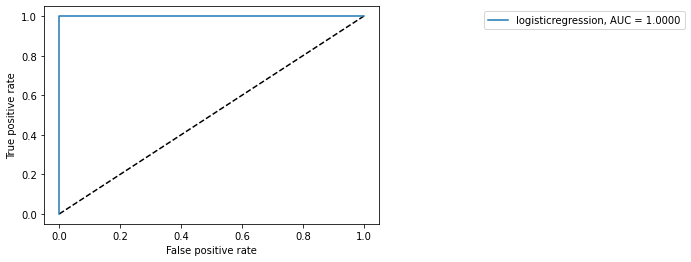

*****************************************************************
precision recall plot:



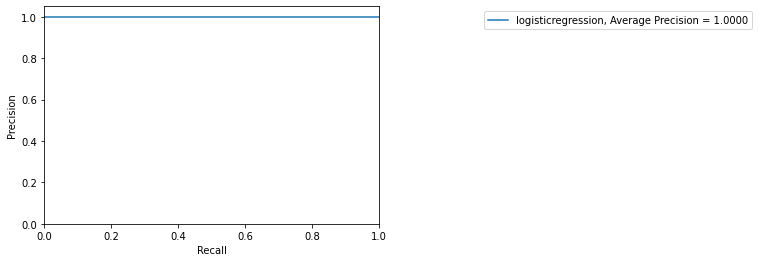

*****************************************************************
callibration plot:



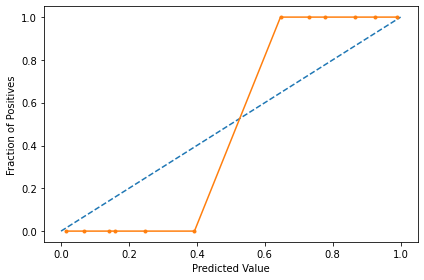

In [19]:
print("The results of the final best model on the test set:\n")
final_best_model = final_best.classifier
final_best_model.results(X_valid=X_test, y_valid=y_test, gen_report=True)